In [10]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False

In [7]:
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "data/PetImages/Cat"
    DOGS = "data/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}

    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1

                except Exception as e:
                    pass
                    # print(str(e))


            np.random.shuffle(self.training_data)
            np.save("training_data.npy", np.array(self.training_data, dtype=object))
            print("Cats::," + str(self.catcount))
            print("Dogs::," + str(self.dogcount))

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

data/PetImages/Cat


100%|██████████| 12501/12501 [00:06<00:00, 2046.45it/s]


Cats::,12498
Dogs::,0
data/PetImages/Dog


100%|██████████| 12501/12501 [00:06<00:00, 1842.11it/s]


Cats::,12498
Dogs::,12499


In [9]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [15]:
print(len(training_data))
print(training_data[67]) #dogs
print(training_data[0]) #cats

24997
[array([[ 11,  11,  11, ...,  15,  14,  13],
        [ 13,  12,  13, ...,  14,  13,  13],
        [  9,  10,  12, ...,  15,  15,  14],
        ...,
        [ 11,  10,  12, ..., 120, 127,  61],
        [ 14,  12,  10, ..., 113, 123, 138],
        [ 24,  25,  24, ..., 174, 177, 182]], shape=(50, 50), dtype=uint8)
 array([0., 1.])]
[array([[107, 109, 111, ...,  37,  37,  34],
        [109,  99, 118, ...,  32,  31,  33],
        [ 95, 118, 135, ...,  35,  33,  31],
        ...,
        [ 81,  86,  86, ...,  27,  24,  22],
        [ 87,  89,  92, ...,  34,  53,  73],
        [ 88,  92,  98, ...,  89,  89,  86]], shape=(50, 50), dtype=uint8)
 array([1., 0.])]


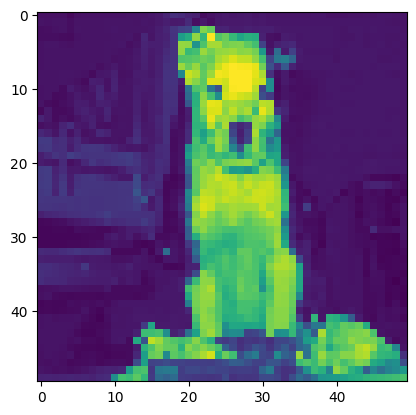

In [21]:
import matplotlib.pyplot as plt

plt.imshow(training_data[67][0])
plt.show()